# Jet Compression using an Autoencoder

In [67]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

import corner as corn

from my_nn_modules import AE_big, get_data, fit, AE_3D_200

import utils

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

unnormed_train = pd.read_pickle(BIN + 'processed_data/train.pkl')
unnormed_test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
def log_normalize(train, test=None):
    train['pT'] = train['pT'].apply(lambda x :np.log10(x) / 3.)
    train['E'] = train['E'].apply(lambda x : np.log10(x) / 3.)
    train['eta'] = train['eta'] / 3.
    train['phi'] = train['phi'] / 3.
    if test is not None:
        test['pT'] = test['pT'].apply(lambda x :np.log10(x) / 3.)
        test['E'] = test['E'].apply(lambda x : np.log10(x) / 3.)
        test['eta'] = test['eta'] / 3.
        test['phi'] = test['phi'] / 3.
    
        return train.astype('float32'), test.astype('float32')
    else:
        return train.astype('float32')

In [5]:
train, test = log_normalize(train, test)

In [6]:
test

,pT,eta,phi,E
1586759,0.751901,-0.583435,0.421524,0.909258
355555,0.761725,0.135155,0.263202,0.773634
1562615,0.752377,-0.625636,-0.613203,0.927210
25428,0.846623,-0.802133,-0.491634,1.095830
1291372,0.750156,-0.538959,-0.630170,0.889492
...,...,...,...,...
968705,0.743690,-0.102638,0.074208,0.750894
1136375,0.786725,-0.596868,0.458433,0.949833
1356104,0.781986,0.105847,0.059019,0.790311
484147,0.713573,0.251696,-1.040768,0.751844


In [7]:
def get_log_normalized_dls(train, test, bs=1024):
    train, test = log_normalize(train, test)
    
    train_x = train
    test_x = test
    train_y = train_x  # y = x since we are building and AE
    test_y = test_x

    train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
    valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))
    
    train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
    
    return train_dl, valid_dl
    

In [8]:
# Normalize
#train_mean = train.mean()
#train_std = train.std()

#train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
#test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [9]:
print(train.shape, test.shape)

(1550321, 4) (387581, 4)


(array([0., 0., 0., 0., ..., 0., 0., 0., 0.]),
 array([0.  , 0.02, 0.04, 0.06, ..., 1.94, 1.96, 1.98, 2.  ], dtype=float32),
 <a list of 100 Patch objects>)

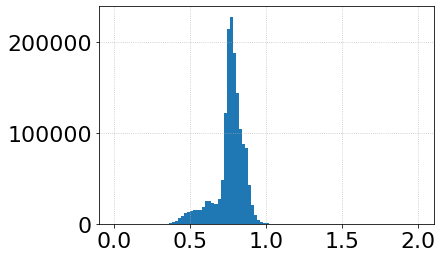

In [10]:
plt.hist(train['pT'], bins=100, range=(0, 2))

## Training

In [11]:
bs = 1024  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [12]:
class AE(nn.Module):
    def __init__(self, n_features=4):
        super(AE, self).__init__()
        self.en1 = nn.Linear(n_features, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.en2 = nn.Linear(50, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.en3 = nn.Linear(50, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.en4 = nn.Linear(20, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 20)
        self.bn6 = nn.BatchNorm1d(20)
        self.de2 = nn.Linear(20, 50)
        self.bn7 = nn.BatchNorm1d(50)
        self.de3 = nn.Linear(50, 50)
        self.bn8 = nn.BatchNorm1d(50)
        self.de4 = nn.Linear(50, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        h1 = self.bn1(self.tanh(self.en1(x)))
        h2 = self.bn2(self.tanh(self.en2(h1)))
        h3 = self.bn3(self.tanh(self.en3(h2)))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.bn6(self.tanh(self.de1(self.bn5(self.tanh(x)))))
        h6 = self.bn7(self.tanh(self.de2(h5)))
        h7 = self.bn8(self.tanh(self.de3(h6)))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        pass
    
class AE_3D_50(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_50, self).__init__()
        self.en1 = nn.Linear(n_features, 50)
        self.en2 = nn.Linear(50, 50)
        self.en3 = nn.Linear(50, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 50)
        self.de3 = nn.Linear(50, 50)
        self.de4 = nn.Linear(50, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-50-50-20-3-20-50-50-out'

In [14]:
n_features = len(train.loc[0])
model = AE_3D_200()

In [15]:
# Training
epochs_list = [1, 7, 5, 3, 3, 3]
lrs = [1e-7, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    _ = fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-07
Epoch: 0 Train Loss: 5.475e-01 Val Loss: 5.388e-01, Time: 0:00:51.631454
Training complete in 0m 52s
Setting learning rate to 1.0e-03
Epoch: 0 Train Loss: 4.318e-03 Val Loss: 3.567e-05, Time: 0:00:51.191907
Epoch: 1 Train Loss: 6.461e-05 Val Loss: 9.400e-06, Time: 0:00:50.905314
Epoch: 2 Train Loss: 5.813e-05 Val Loss: 2.067e-05, Time: 0:00:49.813410
Epoch: 3 Train Loss: 4.331e-05 Val Loss: 8.203e-06, Time: 0:00:50.896896
Epoch: 4 Train Loss: 3.891e-05 Val Loss: 4.322e-05, Time: 0:00:50.273010
Epoch: 5 Train Loss: 3.308e-05 Val Loss: 7.185e-06, Time: 0:00:51.224903
Epoch: 6 Train Loss: 3.067e-05 Val Loss: 6.419e-05, Time: 0:00:51.161395
Training complete in 5m 55s
Setting learning rate to 3.0e-04
Epoch: 0 Train Loss: 8.315e-06 Val Loss: 7.343e-06, Time: 0:00:50.821353
Epoch: 1 Train Loss: 3.570e-06 Val Loss: 1.369e-06, Time: 0:00:50.950609
Epoch: 2 Train Loss: 3.659e-06 Val Loss: 1.856e-06, Time: 0:00:51.389800
Epoch: 3 Train Loss: 3.496e-06 Val Loss: 2

In [27]:
def logunnormalized_reconstructions(model, unnormed_df, idxs=None):
    normed_df = log_normalize(unnormed_df.copy())
    
    if idxs is not None:
        data = torch.tensor(normed_df[idxs[0]:idxs[1]].values)
        unnormed_df = torch.tensor(unnormed_df[idxs[0]:idxs[1]].values)
    else:
        data = torch.tensor(normed_df.values)
        unnormed_df = torch.tensor(unnormed_df.values)
        
    pred = model(data)#.detach().numpy()
    pred = pred * 3
    pred[:, 0] = 10**(pred[:, 0])
    pred[:, 3] = 10**(pred[:, 3])
    
    return pred

In [16]:
opt = optim.Adam(model.parameters(), lr=1e-4)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 9.036e-07 Val Loss: 9.226e-07, Time: 0:00:50.032608
Epoch: 1 Train Loss: 4.867e-07 Val Loss: 2.366e-07, Time: 0:00:50.533565
Epoch: 2 Train Loss: 5.033e-07 Val Loss: 2.421e-07, Time: 0:00:51.037090
Epoch: 3 Train Loss: 5.196e-07 Val Loss: 1.795e-07, Time: 0:00:50.591322
Epoch: 4 Train Loss: 4.737e-07 Val Loss: 3.782e-07, Time: 0:00:50.557240
Epoch: 5 Train Loss: 4.902e-07 Val Loss: 2.355e-07, Time: 0:00:50.198781
Epoch: 6 Train Loss: 4.734e-07 Val Loss: 8.050e-07, Time: 0:00:50.416188
Epoch: 7 Train Loss: 4.835e-07 Val Loss: 3.691e-07, Time: 0:00:49.631122
Epoch: 8 Train Loss: 4.835e-07 Val Loss: 3.163e-07, Time: 0:00:50.456143
Epoch: 9 Train Loss: 4.696e-07 Val Loss: 5.082e-07, Time: 0:00:51.904244
Training complete in 8m 25s


,Epoch,val_loss,train_loss,epoch_time
0,0,9.225899e-07,9.035729e-07,51.904244
1,1,2.366327e-07,4.866572e-07,51.904244
2,2,2.420629e-07,5.033343e-07,51.904244
3,3,1.795422e-07,5.196080e-07,51.904244
4,4,3.781931e-07,4.737249e-07,51.904244
5,5,2.355495e-07,4.901580e-07,51.904244
6,6,8.049566e-07,4.733880e-07,51.904244
7,7,3.691429e-07,4.835017e-07,51.904244
8,8,3.163289e-07,4.834594e-07,51.904244
9,9,5.082127e-07,4.696384e-07,51.904244


In [17]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 1.002e-07 Val Loss: 9.538e-08, Time: 0:00:50.397595
Epoch: 1 Train Loss: 9.555e-08 Val Loss: 9.273e-08, Time: 0:00:49.971456
Epoch: 2 Train Loss: 9.295e-08 Val Loss: 9.126e-08, Time: 0:00:50.689595
Epoch: 3 Train Loss: 9.066e-08 Val Loss: 8.552e-08, Time: 0:00:49.797763
Epoch: 4 Train Loss: 8.879e-08 Val Loss: 8.046e-08, Time: 0:00:49.132034
Epoch: 5 Train Loss: 8.687e-08 Val Loss: 8.280e-08, Time: 0:00:50.559452
Epoch: 6 Train Loss: 8.523e-08 Val Loss: 8.370e-08, Time: 0:00:50.133868
Epoch: 7 Train Loss: 8.314e-08 Val Loss: 1.203e-07, Time: 0:00:49.900434
Epoch: 8 Train Loss: 8.221e-08 Val Loss: 7.732e-08, Time: 0:00:50.360946
Epoch: 9 Train Loss: 8.046e-08 Val Loss: 7.429e-08, Time: 0:00:50.771179
Training complete in 8m 22s


,Epoch,val_loss,train_loss,epoch_time
0,0,9.538082e-08,1.002405e-07,50.771179
1,1,9.273242e-08,9.554888e-08,50.771179
2,2,9.126119e-08,9.295039e-08,50.771179
3,3,8.551513e-08,9.065917e-08,50.771179
4,4,8.046278e-08,8.879362e-08,50.771179
5,5,8.280477e-08,8.686954e-08,50.771179
6,6,8.369885e-08,8.522780e-08,50.771179
7,7,1.203139e-07,8.314306e-08,50.771179
8,8,7.731949e-08,8.220563e-08,50.771179
9,9,7.429101e-08,8.046357e-08,50.771179


In [18]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 8.205e-08 Val Loss: 7.523e-08, Time: 0:00:50.177057
Epoch: 1 Train Loss: 7.779e-08 Val Loss: 7.411e-08, Time: 0:00:50.335956
Epoch: 2 Train Loss: 7.669e-08 Val Loss: 7.664e-08, Time: 0:00:50.471236
Epoch: 3 Train Loss: 7.533e-08 Val Loss: 7.259e-08, Time: 0:00:50.142463
Epoch: 4 Train Loss: 7.426e-08 Val Loss: 7.138e-08, Time: 0:00:50.300431
Epoch: 5 Train Loss: 7.326e-08 Val Loss: 7.310e-08, Time: 0:00:51.000562
Epoch: 6 Train Loss: 7.235e-08 Val Loss: 7.127e-08, Time: 0:00:50.214841
Epoch: 7 Train Loss: 7.110e-08 Val Loss: 6.698e-08, Time: 0:00:49.978243
Epoch: 8 Train Loss: 7.016e-08 Val Loss: 6.682e-08, Time: 0:00:50.315307
Epoch: 9 Train Loss: 6.935e-08 Val Loss: 8.152e-08, Time: 0:00:50.279851
Training complete in 8m 23s


,Epoch,val_loss,train_loss,epoch_time
0,0,7.523328e-08,8.205401e-08,50.279851
1,1,7.411350e-08,7.778976e-08,50.279851
2,2,7.663781e-08,7.668676e-08,50.279851
3,3,7.259233e-08,7.532982e-08,50.279851
4,4,7.137506e-08,7.425709e-08,50.279851
5,5,7.310186e-08,7.326120e-08,50.279851
6,6,7.126776e-08,7.235438e-08,50.279851
7,7,6.698303e-08,7.109659e-08,50.279851
8,8,6.681729e-08,7.016343e-08,50.279851
9,9,8.151658e-08,6.935281e-08,50.279851


In [19]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 6.373e-08 Val Loss: 6.266e-08, Time: 0:00:50.051963
Epoch: 1 Train Loss: 6.316e-08 Val Loss: 6.282e-08, Time: 0:00:49.509320
Epoch: 2 Train Loss: 6.264e-08 Val Loss: 6.193e-08, Time: 0:00:50.100490
Epoch: 3 Train Loss: 6.228e-08 Val Loss: 6.059e-08, Time: 0:00:50.015616
Epoch: 4 Train Loss: 6.189e-08 Val Loss: 6.074e-08, Time: 0:00:50.006322
Epoch: 5 Train Loss: 6.135e-08 Val Loss: 6.095e-08, Time: 0:00:50.116923
Epoch: 6 Train Loss: 6.093e-08 Val Loss: 6.003e-08, Time: 0:00:50.210537
Epoch: 7 Train Loss: 6.049e-08 Val Loss: 5.979e-08, Time: 0:00:49.922867
Epoch: 8 Train Loss: 6.013e-08 Val Loss: 6.031e-08, Time: 0:00:50.203654
Epoch: 9 Train Loss: 5.974e-08 Val Loss: 5.874e-08, Time: 0:00:49.852974
Training complete in 8m 20s


,Epoch,val_loss,train_loss,epoch_time
0,0,6.265996e-08,6.372524e-08,49.852974
1,1,6.281863e-08,6.316131e-08,49.852974
2,2,6.193006e-08,6.264269e-08,49.852974
3,3,6.058947e-08,6.227623e-08,49.852974
4,4,6.074088e-08,6.188852e-08,49.852974
5,5,6.095316e-08,6.134747e-08,49.852974
6,6,6.002595e-08,6.093408e-08,49.852974
7,7,5.978584e-08,6.049275e-08,49.852974
8,8,6.031086e-08,6.012956e-08,49.852974
9,9,5.873950e-08,5.974017e-08,49.852974


In [20]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 5.948e-08 Val Loss: 5.868e-08, Time: 0:00:50.399312
Epoch: 1 Train Loss: 5.887e-08 Val Loss: 5.902e-08, Time: 0:00:50.345944
Epoch: 2 Train Loss: 5.854e-08 Val Loss: 5.787e-08, Time: 0:00:50.238202
Epoch: 3 Train Loss: 5.820e-08 Val Loss: 5.682e-08, Time: 0:00:51.220195
Epoch: 4 Train Loss: 5.785e-08 Val Loss: 5.757e-08, Time: 0:00:49.371996
Epoch: 5 Train Loss: 5.750e-08 Val Loss: 5.753e-08, Time: 0:00:52.032687
Epoch: 6 Train Loss: 5.706e-08 Val Loss: 5.744e-08, Time: 0:00:51.692111
Epoch: 7 Train Loss: 5.678e-08 Val Loss: 5.593e-08, Time: 0:00:50.825597
Epoch: 8 Train Loss: 5.640e-08 Val Loss: 5.577e-08, Time: 0:00:50.614547
Epoch: 9 Train Loss: 5.602e-08 Val Loss: 5.543e-08, Time: 0:00:49.932153
Training complete in 8m 27s


,Epoch,val_loss,train_loss,epoch_time
0,0,5.867972e-08,5.947510e-08,49.932153
1,1,5.902031e-08,5.886552e-08,49.932153
2,2,5.787338e-08,5.853649e-08,49.932153
3,3,5.681630e-08,5.819847e-08,49.932153
4,4,5.756899e-08,5.784923e-08,49.932153
5,5,5.752788e-08,5.749631e-08,49.932153
6,6,5.744274e-08,5.706276e-08,49.932153
7,7,5.593425e-08,5.677982e-08,49.932153
8,8,5.576501e-08,5.639945e-08,49.932153
9,9,5.542995e-08,5.601726e-08,49.932153


In [21]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 5.477e-08 Val Loss: 5.431e-08, Time: 0:00:49.695751
Epoch: 1 Train Loss: 5.460e-08 Val Loss: 5.405e-08, Time: 0:00:49.862912
Epoch: 2 Train Loss: 5.447e-08 Val Loss: 5.408e-08, Time: 0:00:50.143798
Epoch: 3 Train Loss: 5.431e-08 Val Loss: 5.398e-08, Time: 0:00:50.791703
Epoch: 4 Train Loss: 5.415e-08 Val Loss: 5.371e-08, Time: 0:00:50.134512
Epoch: 5 Train Loss: 5.397e-08 Val Loss: 5.361e-08, Time: 0:00:50.588145
Epoch: 6 Train Loss: 5.386e-08 Val Loss: 5.332e-08, Time: 0:00:49.794983
Epoch: 7 Train Loss: 5.365e-08 Val Loss: 5.331e-08, Time: 0:00:50.240105
Epoch: 8 Train Loss: 5.353e-08 Val Loss: 5.344e-08, Time: 0:00:50.255298
Epoch: 9 Train Loss: 5.339e-08 Val Loss: 5.315e-08, Time: 0:00:49.786024
Training complete in 8m 21s


,Epoch,val_loss,train_loss,epoch_time
0,0,5.431499e-08,5.477437e-08,49.786024
1,1,5.404677e-08,5.459623e-08,49.786024
2,2,5.408232e-08,5.447068e-08,49.786024
3,3,5.398466e-08,5.430918e-08,49.786024
4,4,5.370532e-08,5.414659e-08,49.786024
5,5,5.360634e-08,5.396870e-08,49.786024
6,6,5.332474e-08,5.385509e-08,49.786024
7,7,5.330830e-08,5.365266e-08,49.786024
8,8,5.343632e-08,5.352623e-08,49.786024
9,9,5.315456e-08,5.339395e-08,49.786024


In [22]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(30, model, loss_func, opt, train_dl, valid_dl, device)

Epoch: 0 Train Loss: 5.325e-08 Val Loss: 5.332e-08, Time: 0:00:50.384813
Epoch: 1 Train Loss: 5.310e-08 Val Loss: 5.301e-08, Time: 0:00:49.798304
Epoch: 2 Train Loss: 5.294e-08 Val Loss: 5.269e-08, Time: 0:00:50.759751
Epoch: 3 Train Loss: 5.284e-08 Val Loss: 5.259e-08, Time: 0:00:51.259712
Epoch: 4 Train Loss: 5.265e-08 Val Loss: 5.261e-08, Time: 0:00:50.343740
Epoch: 5 Train Loss: 5.252e-08 Val Loss: 5.214e-08, Time: 0:00:51.205835
Epoch: 6 Train Loss: 5.237e-08 Val Loss: 5.189e-08, Time: 0:00:49.631135
Epoch: 7 Train Loss: 5.223e-08 Val Loss: 5.186e-08, Time: 0:00:50.509264
Epoch: 8 Train Loss: 5.208e-08 Val Loss: 5.178e-08, Time: 0:00:50.125459
Epoch: 9 Train Loss: 5.193e-08 Val Loss: 5.215e-08, Time: 0:00:50.096302
Epoch: 10 Train Loss: 5.180e-08 Val Loss: 5.148e-08, Time: 0:00:50.815987
Epoch: 11 Train Loss: 5.165e-08 Val Loss: 5.133e-08, Time: 0:00:50.121045
Epoch: 12 Train Loss: 5.151e-08 Val Loss: 5.131e-08, Time: 0:00:50.229179
Epoch: 13 Train Loss: 5.135e-08 Val Loss: 5.133e

,Epoch,val_loss,train_loss,epoch_time
0,0,5.331800e-08,5.324848e-08,50.732909
1,1,5.301434e-08,5.309669e-08,50.732909
2,2,5.269323e-08,5.293633e-08,50.732909
3,3,5.259070e-08,5.283967e-08,50.732909
4,4,5.260896e-08,5.264727e-08,50.732909
5,5,5.214475e-08,5.251968e-08,50.732909
6,6,5.188772e-08,5.237288e-08,50.732909
7,7,5.185652e-08,5.223188e-08,50.732909
8,8,5.178333e-08,5.208267e-08,50.732909
9,9,5.215360e-08,5.192632e-08,50.732909


In [28]:
pred = logunnormalized_reconstructions(model, unnormed_test)
pred

tensor([[ 1.8007e+02, -1.7497e+00,  1.2647e+00,  5.3455e+02],
        [ 1.9246e+02,  4.0565e-01,  7.8972e-01,  2.0970e+02],
        [ 1.8065e+02, -1.8764e+00, -1.8393e+00,  6.0549e+02],
        ...,
        [ 2.2194e+02,  3.1807e-01,  1.7723e-01,  2.3481e+02],
        [ 1.3825e+02,  7.5491e-01, -3.1224e+00,  1.8009e+02],
        [ 9.3180e+01,  3.2857e+00,  2.6570e+00,  1.2395e+03]],
       grad_fn=<CopySlices>)

In [29]:
unnormed_test

,pT,eta,phi,E
1586759,180.178299,-1.750306,1.264573,534.287720
355555,192.830658,0.405465,0.789605,209.364288
1562615,180.772522,-1.876908,-1.839610,604.824036
25428,346.631470,-2.406398,-1.474901,1938.605103
1291372,178.019989,-1.616878,-1.890509,466.095917
...,...,...,...,...
968705,170.243225,-0.307913,0.222623,178.930084
1136375,229.178604,-1.790605,1.375299,707.127441
1356104,221.798065,0.317542,0.177057,234.926453
484147,138.267014,0.755089,-3.122304,180.107529


In [30]:
unnormed_loss = loss_func(input=torch.tensor(unnormed_test.values), target=pred)
# utils.validate(model, dl=pred)

In [31]:
unnormed_loss

tensor(0.9075, grad_fn=<MeanBackward0>)

In [33]:
old_model = AE_3D_200()
save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
old_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [34]:
utils.validate(model=old_model, dl=valid_dl, loss_func=nn.MSELoss())

0.3262503868287605


0.3262503868287605

In [23]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_3D_200_lognormalized_loss_49eneg9.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [24]:
model.eval()

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [25]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 0.8781, -0.3844,  1.0318,  0.9586])
Out: tensor([ 0.8782, -0.3843,  1.0319,  0.9586], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.7980, -0.0949, -0.0159,  0.8047])
Out: tensor([ 0.7980, -0.0949, -0.0159,  0.8048], grad_fn=<AddBackward0>)
 
Inp: tensor([0.7525, 0.3388, 0.7945, 0.8174])
Out: tensor([0.7526, 0.3389, 0.7945, 0.8172], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.7528, -0.0111,  0.6644,  0.7533])
Out: tensor([ 0.7525, -0.0110,  0.6643,  0.7537], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.7064, -0.2181,  0.7056,  0.7356])
Out: tensor([ 0.7063, -0.2181,  0.7055,  0.7357], grad_fn=<AddBackward0>)
 


In [ ]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

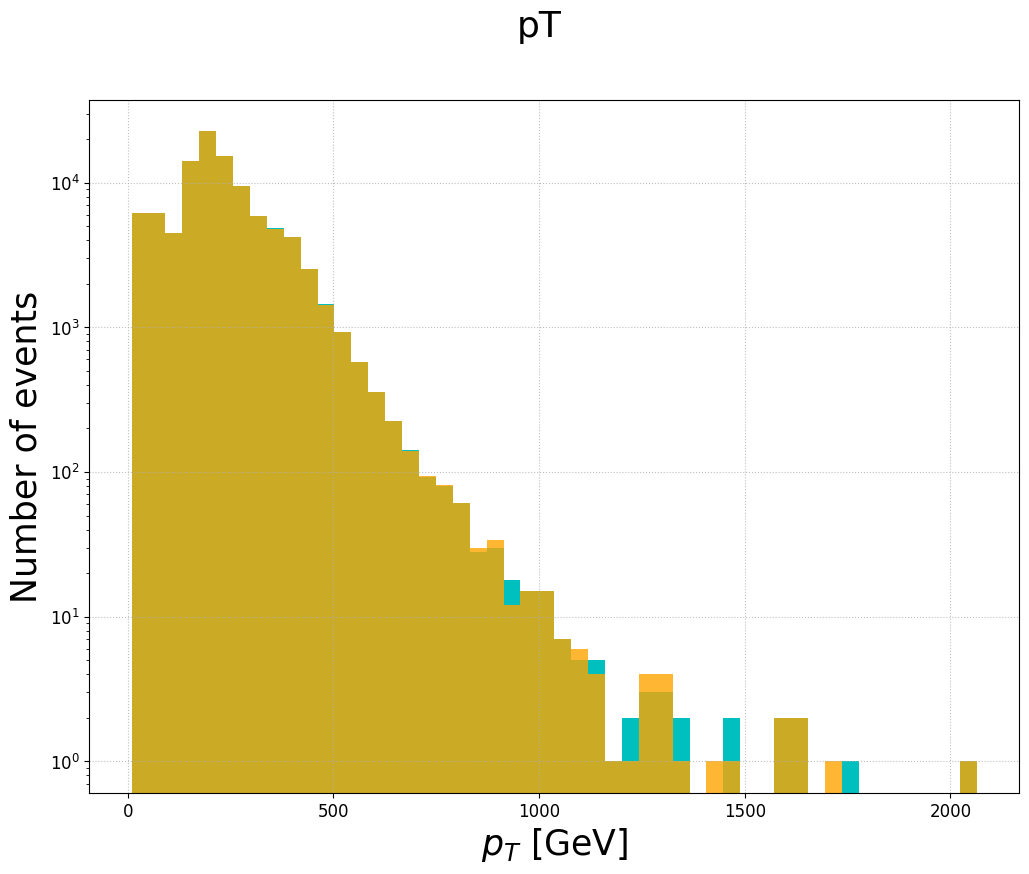

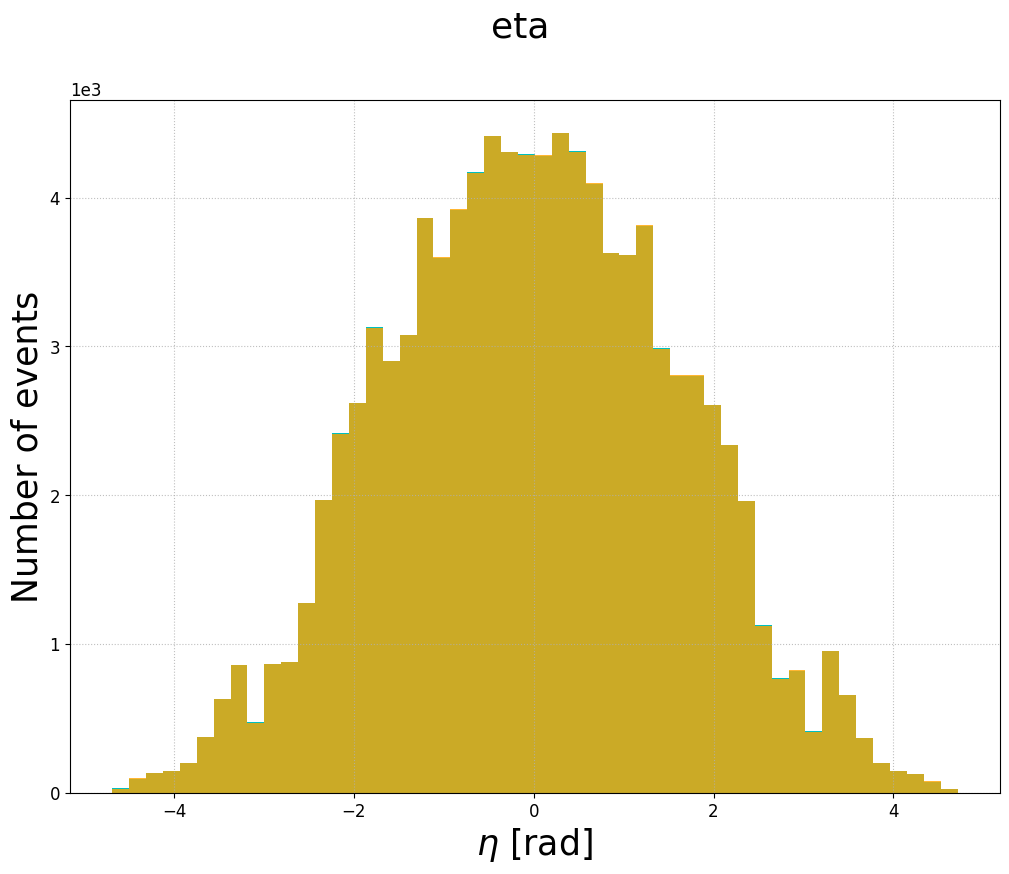

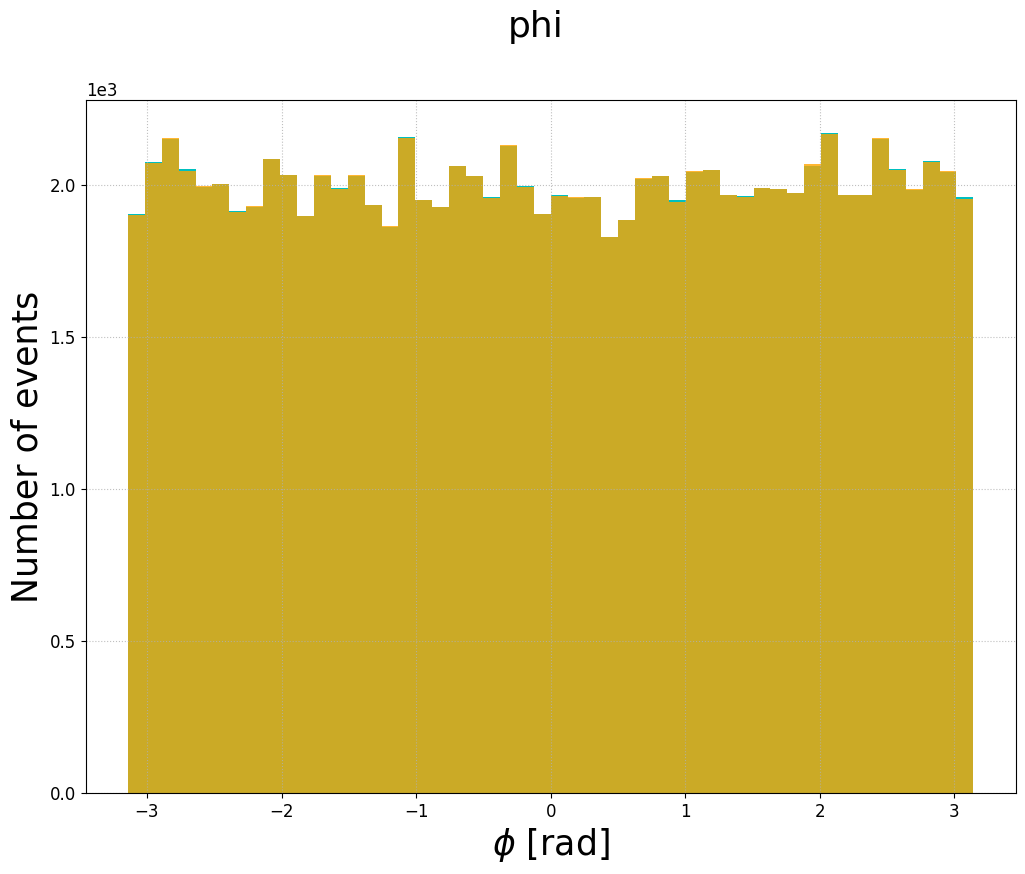

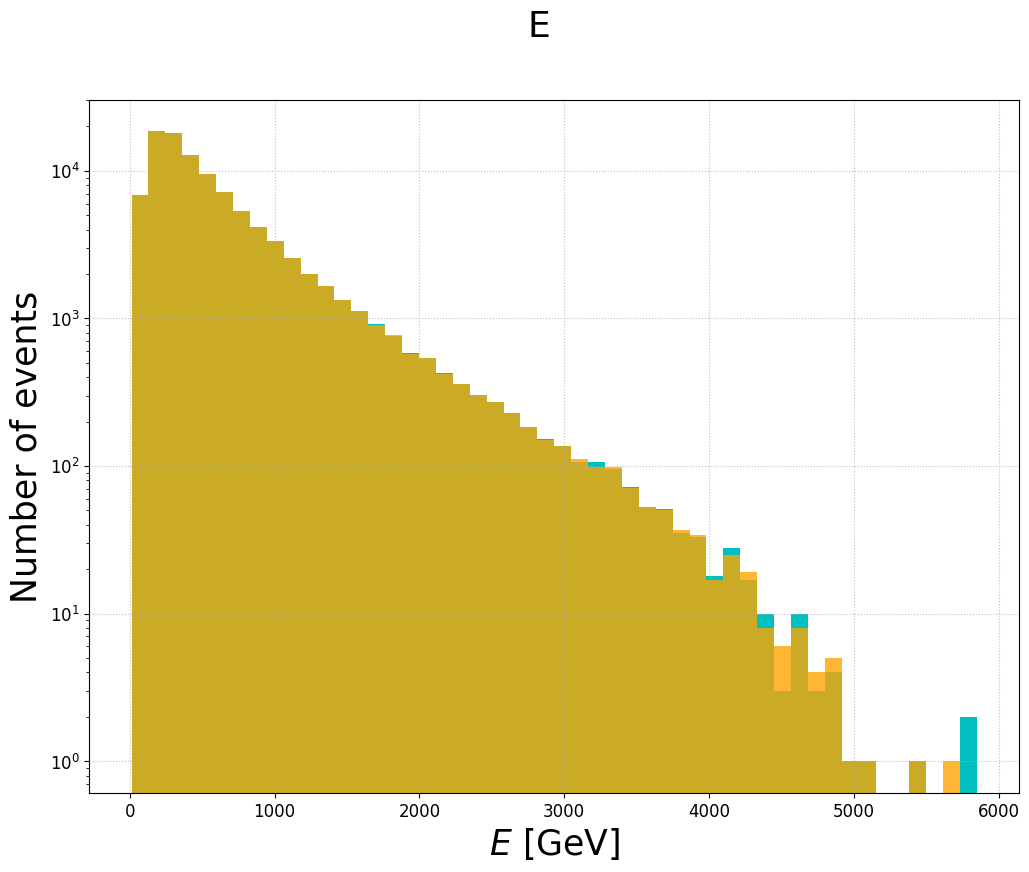

In [74]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, int(1e5))  # Choose events to compare
data = torch.tensor(unnormed_test[idxs[0]:idxs[1]].values)
pred = logunnormalized_reconstructions(model, unnormed_test, idxs=idxs)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    if (kk == 0) or (kk == 3):
        plt.yscale('log')
    else:
        ms.sciy()

In [75]:
data

tensor([[ 1.8018e+02, -1.7503e+00,  1.2646e+00,  5.3429e+02],
        [ 1.9283e+02,  4.0547e-01,  7.8960e-01,  2.0936e+02],
        [ 1.8077e+02, -1.8769e+00, -1.8396e+00,  6.0482e+02],
        ...,
        [ 3.2412e+02,  1.3075e-01,  2.4593e-01,  3.2727e+02],
        [ 1.5006e+02, -2.0135e-01, -2.1251e+00,  1.5474e+02],
        [ 2.5025e+02, -1.8037e-01, -2.3984e+00,  2.5453e+02]])

In [76]:
utils.rms(residuals[:, 0])

0.0019404876755173936

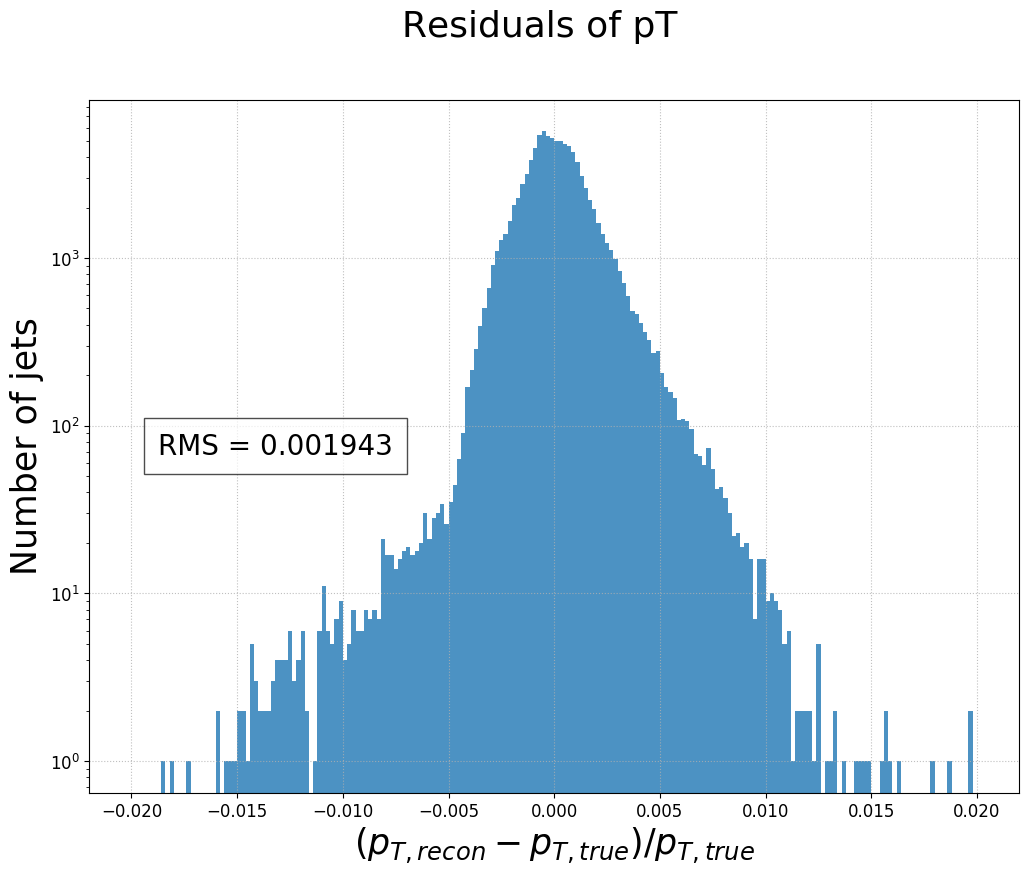

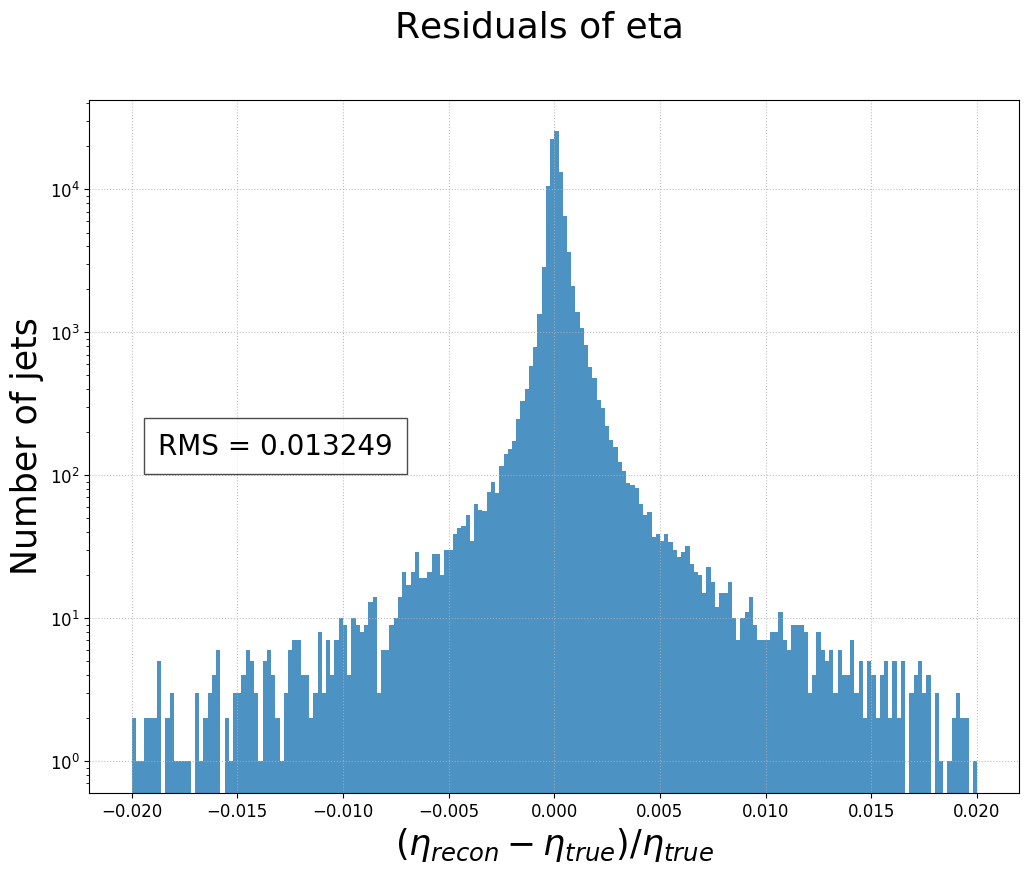

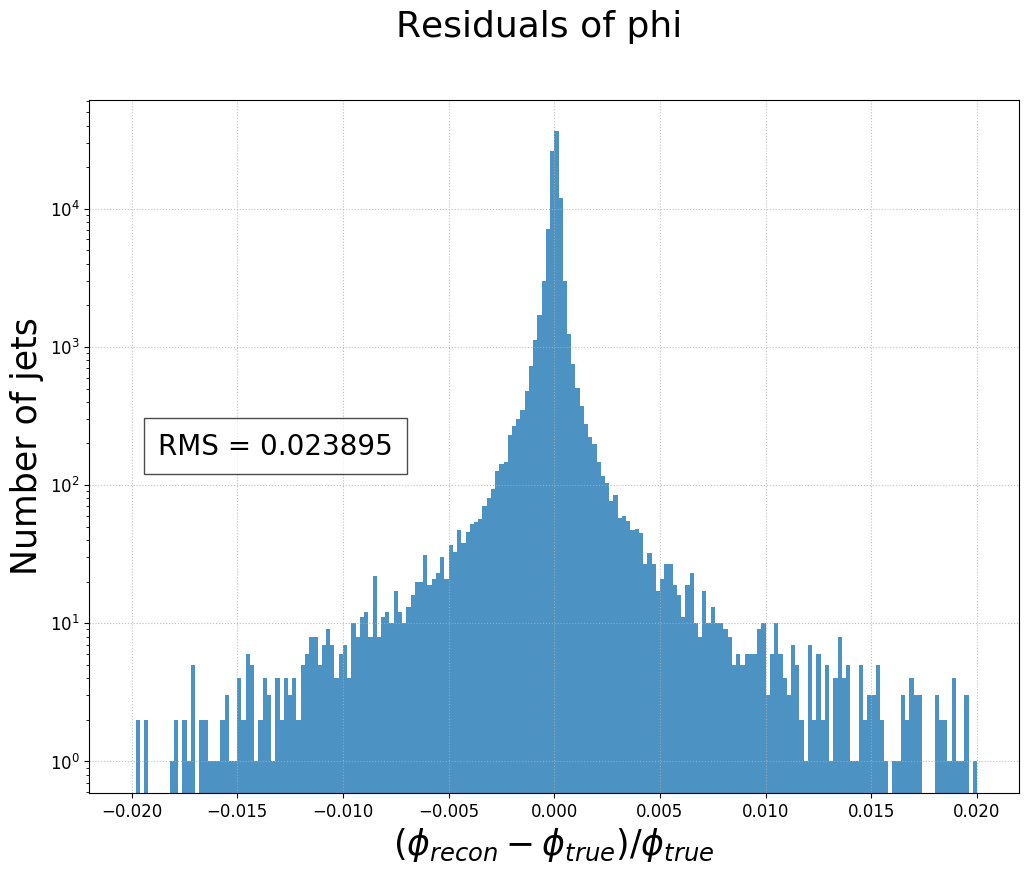

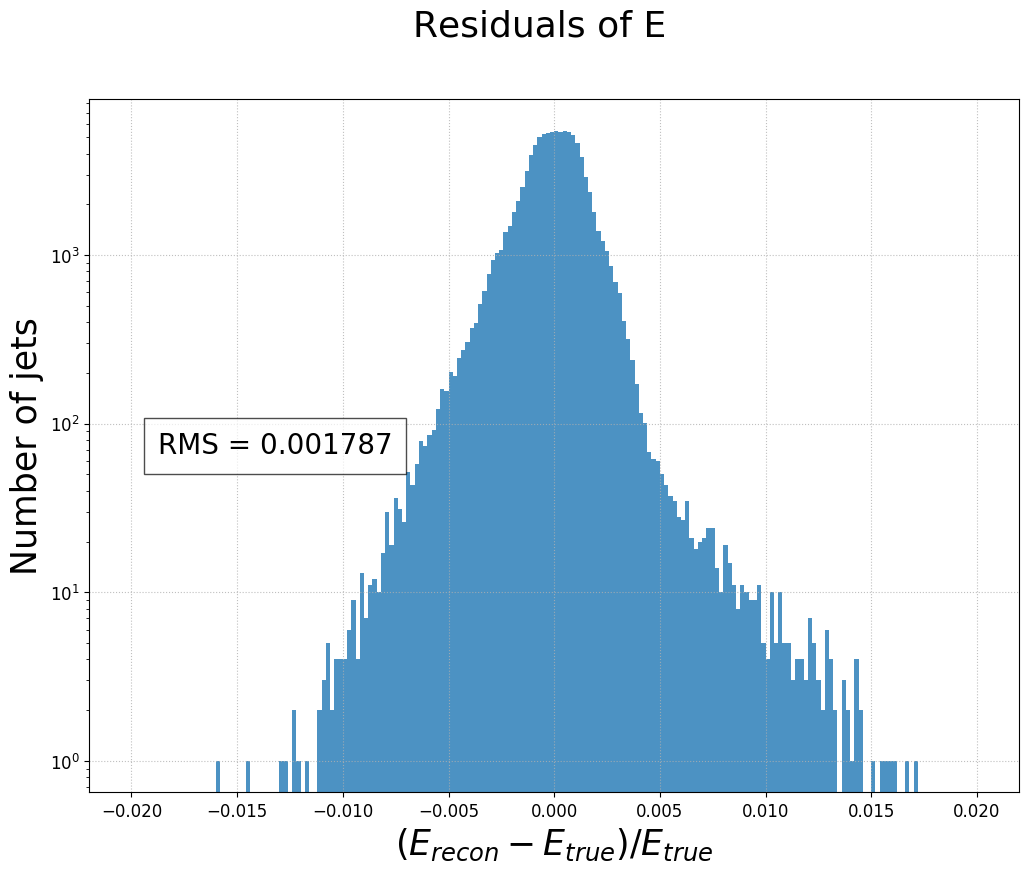

In [85]:
residual_strings = [r'$(p_{T,recon} - p_{T,true}) / p_{T,true}$',
                    r'$(\eta_{recon} - \eta_{true}) / \eta_{true}$',
                    r'$(\phi_{recon} - \phi_{true}) / \phi_{true}$',
                    r'$(E_{recon} - E_{true}) / E_{true}$']
save = False
residuals = (pred.detach().numpy() - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=200, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
#    ms.sciy()
    plt.yscale('log')
    rms = utils.rms(residuals[:, kk])
    ax = plt.gca()
    plt.text(.2, .5, 'RMS = %f' % (rms), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    if save:
        plt.savefig(figures_path + prefix + '_residuals_' + train.columns[kk])


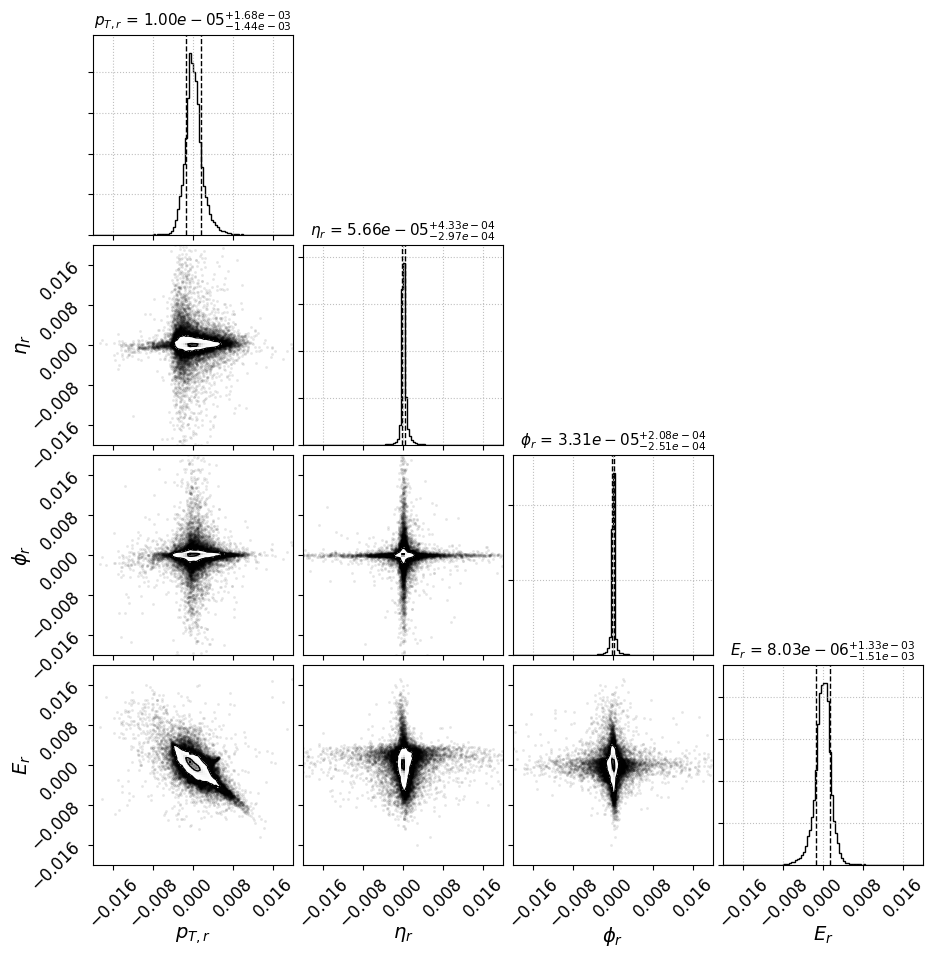

In [87]:
label_kwargs = {'fontsize': 14}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
corner_labels = [r'$p_{T,r}$', r'$\eta_{r}$', r'$\phi_{r}$', r'$E_{r}$']
_ = corn.corner(residuals, range=[range for i in np.arange(residuals.shape[1])],
            bins=100, labels=corner_labels, label_kwargs=label_kwargs,
            show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
            levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')

In [ ]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [ ]:
# Plot input on top of output
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

In [ ]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=1)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

In [ ]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')